## Final Project Submission¶

Student name: Eduardo Osorio

Student pace: part time 

Scheduled project review date/time:

Instructor name: Yish Lim

Blog post URL:

In [1]:
import pandas as pd
import numpy as np


kcc = pd.read_csv('data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot']
categoricals = ['bedrooms', 'floors', 'condition', 'waterfront', 'grade', 'zipcode', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# kcc_log_norm = kcc_log.apply(normalize)

# one hot encode categoricals
kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors','condition', 'waterfront', 'zipcode', 'grade', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log, kcc_ohe], axis=1)

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

In [6]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grade_10                       with p-value 0.0
Add  grade_9                        with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  grade_11                       with p-value 5.40535e-149
Add  zipcode_98023                  with p-value 6.07803e-147
Add  zipcode_98004                  with p-value 1.6457e-134
Add  zipcode_98042                  with p-value 9.79653e-119
Add  waterfront_1.0                 with p-value 2.50108e-112
Add  grade_8                        with p-value 2.41449e-117
Add  grade_12                       with p-value 2.45053e-126
Add  zipcode_98112                  with p-value 8.89403e-108
Add  zipcode_98092                  with p-value 3.11201e-106
Add  zipcode_98115                  with p-value 1.17609e-103
Add  zipcode_98103                  with p-value 2.41446e-107
Add  zipcode_98117                  with p-value 1.74719e-109
Add  zipcode_98105                  with p-value 1.09911e-97
Add  zipcode_98199                  w

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zipcode_98019                  with p-value 1.24266e-12
Drop zipcode_98038                  with p-value 0.1012
Add  zipcode_98045                  with p-value 1.61476e-16
Drop zipcode_98055                  with p-value 0.150715
Add  zipcode_98146                  with p-value 4.29093e-19
Drop zipcode_98058                  with p-value 0.585176
Add  zipcode_98024                  with p-value 2.89141e-17
Add  zipcode_98014                  with p-value 1.66838e-09
Add  zipcode_98070                  with p-value 2.64427e-09
Add  condition_2                    with p-value 5.85638e-08
Add  zipcode_98038                  with p-value 5.21907e-07
Drop zipcode_98198                  with p-value 0.148034
Add  zipcode_98178                  with p-value 1.46263e-07
Drop zipcode_98188                  with p-value 0.440481
Add  zipcode_98058                  with p-value 6.59457e-07
Drop zipcode_98031                  with p-value 0.354096
Add  zipcode_98010                  with p-v

In [7]:
import statsmodels.api as sm
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1241.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:09:39   Log-Likelihood:                 4033.8
No. Observations:               15372   AIC:                            -7890.
Df Residuals:                   15283   BIC:                            -7210.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.8562      0.062    127.540      0.000       7.736       7.977
grade_10            0.4508      0.011     41.075      0.000       0.429       0.472
grade_9             0.3411      0.009     38.409      0.000       0.324       0.359
sqft_living_log     0.4688      0.006     74.736      0.000       0.457       0.481
grade_11            0.6071      0.015     40.904      0.000       0.578       0.636
zipcode_98023      -0.0702      0.011     -6.336      0.000      -0.092      -0.048
zipcode_98004       1.0759      0.014     77.236      0.000       1.049       1.103
waterfront_1.0      0.6920      0.018     39.062      0.000       0.657       0.727
grade_8             0.1915      0.007     26.745      0.000       0.177       0.205
grade_12            0.7887      0.025     31.448      0.000       0.740       0.838
zipcode_98112       1.0262      0.014     70.906      0.000       0.998       1.055
zipcode_98092      -0.0311      0.013     -2.388      0.017      -0.057      -0.006
zipcode_98115       0.7931      0.011     73.601      0.000       0.772       0.814
zipcode_98103       0.8196      0.011     74.341      0.000       0.798       0.841
zipcode_98117       0.7912      0.011     71.635      0.000       0.770       0.813
zipcode_98105       0.9372      0.016     60.445      0.000       0.907       0.968
zipcode_98199       0.8421      0.014     62.312      0.000       0.816       0.869
zipcode_98040       0.8553      0.015     58.336      0.000       0.827       0.884
zipcode_98033       0.7373      0.012     62.564      0.000       0.714       0.760
zipcode_98119       0.9736      0.018     55.134      0.000       0.939       1.008
zipcode_98107       0.8443      0.015     56.420      0.000       0.815       0.874
zipcode_98039       1.2560      0.030     41.433      0.000       1.197       1.315
zipcode_98116       0.7546      0.013     57.395      0.000       0.729       0.780
zipcode_98122       0.8146      0.014     57.310      0.000       0.787       0.842
zipcode_98003      -0.0359      0.014     -2.532      0.011      -0.064      -0.008
zipcode_98109       0.9845      0.022     45.060      0.000       0.942       1.027
zipcode_98002      -0.0660      0.016     -4.006      0.000      -0.098      -0.034
zipcode_98032      -0.0912      0.020     -4.469      0.000      -0.131      -0.051
condition_3         0.3573      0.041      8.650      0.000       0.276       0.438
zipcode_98102       0.9546      0.024     39.862      0.000       0.908       1.002
grade_13            1.0880      0.058     18.687      0.000       0.974       1.202
grade_7             0.0781      0.006     13.062      0.000       0.066       0.090
sqft_lot_log        0.0710      0.002     29.139      0.000       0.066       0.076
zipcode_98136       0.6960      0.014     48.081      0.000

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 70)
selector = selector.fit(X_fin, y_train.values.ravel()) 
selector.support_ 

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False,  True, False,  True])

In [9]:
selected_columns = X_fin.columns[selector.support_ ]
linreg.fit(X_fin[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
selected_columns

Index(['grade_10', 'grade_9', 'sqft_living_log', 'grade_11', 'zipcode_98004',
       'waterfront_1.0', 'grade_8', 'grade_12', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98103', 'zipcode_98117', 'zipcode_98105',
       'zipcode_98199', 'zipcode_98040', 'zipcode_98033', 'zipcode_98119',
       'zipcode_98107', 'zipcode_98039', 'zipcode_98116', 'zipcode_98122',
       'zipcode_98109', 'condition_3', 'zipcode_98102', 'grade_13',
       'zipcode_98136', 'zipcode_98144', 'zipcode_98006', 'zipcode_98052',
       'zipcode_98008', 'zipcode_98005', 'zipcode_98053', 'zipcode_98177',
       'zipcode_98125', 'zipcode_98034', 'zipcode_98029', 'zipcode_98126',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98007', 'zipcode_98118',
       'zipcode_98027', 'zipcode_98133', 'condition_5', 'condition_4',
       'zipcode_98065', 'zipcode_98155', 'zipcode_98072', 'zipcode_98011',
       'zipcode_98028', 'zipcode_98077', 'zipcode_98059', 'zipcode_98106',
       'zipcode_98108', 'zipcode_98056', 'z

In [11]:
yhat = linreg.predict(X[selected_columns])
y_hat_train = linreg.predict(X_fin[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

In [12]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)

In [13]:
r_squared

0.8628968694399499

In [14]:
adjusted_r_squared

0.8623955782861654

In [15]:
linreg.score(X_fin[selected_columns], y_train)

0.8646491645780046

In [16]:
# def un_normalize(feature):
#     kcc_log.apply(normalize)
#     fm = feature.mean()
#     fs = feature.std
#     return (feature + fm) * fs

# X_fin = X_fin.apply(un_normalize)
# X_test = X_test.apply(un_normalize)
# y_train = y_train.apply(un_normalize)
# y_test = y_test.apply(un_normalize)

In [17]:
# X_fin = np.exp(X_fin)
# X_test = np.exp(X_test)
# y_train = np.exp(y_train)
# y_test = np.exp(y_test)

In [18]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.038195467395405955
Test Mean Squarred Error: 0.03789664662546213


In [19]:
train_error_log = np.sqrt(mse_train)
test_error_log = np.sqrt(mse_test)
print(train_error_log)
print(test_error_log)

0.19543660710165317
0.19467061058480845


In [20]:
train_error = np.exp(train_error_log)
test_error = np.exp(test_error_log)
print('train error:',train_error)
print('test error:', test_error)

train error: 1.2158417157488002
test error: 1.21491074183641


In [21]:
# def un_normalize(feature):
#     return (feature + feature.mean()) * feature.std()

In [22]:
# train_error.apply(un_normalize)
# test_error.apply(un_normalize)

AttributeError: 'numpy.float64' object has no attribute 'apply'

In [23]:
import scipy.stats as stats

In [24]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
# plt.scatter(model.predict(y_hat_train))

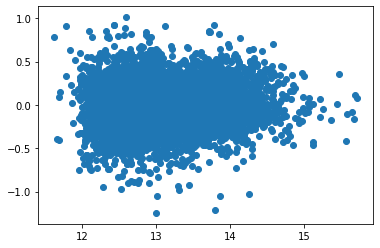

In [27]:
plt.scatter(y_hat_train, model.resid)
# plt.plot(y_hat_train(X_train[selected_columns])

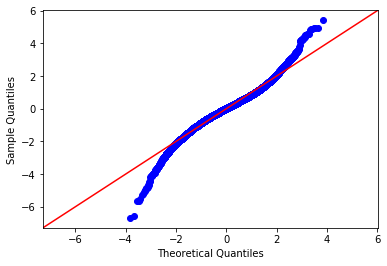

In [28]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [29]:
model = sm.OLS(y_test,X_test[selected_columns]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.056e+05
Date:                Fri, 30 Oct 2020   Prob (F-statistic):                        0.00
Time:                        14:10:22   Log-Likelihood:                         -764.75
No. Observations:                3844   AIC:                                      1669.
Df Residuals:                    3774   BIC:                                      2107.
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
grade_10            0.0194      0.027      0.733      0.464      -0.033       0.071
grade_9            -0.0269      0.018     -1.466      0.143      -0.063       0.009
sqft_living_log     0.9912      0.013     74.765      0.000       0.965       1.017
grade_11           -0.0213      0.040     -0.534      0.593      -0.100       0.057
zipcode_98004       1.2619      0.039     32.745      0.000       1.186       1.337
waterfront_1.0      0.7000      0.061     11.527      0.000       0.581       0.819
grade_8            -0.0379      0.013     -3.031      0.002      -0.062      -0.013
grade_12           -0.0174      0.090     -0.193      0.847      -0.194       0.160
zipcode_98112       1.1293      0.047     23.885      0.000       1.037       1.222
zipcode_98115       0.8594      0.031     28.056      0.000       0.799       0.919
zipcode_98103       0.8868      0.030     29.451      0.000       0.828       0.946
zipcode_98117       0.8767      0.030     28.862      0.000       0.817       0.936
zipcode_98105       0.9657      0.048     20.262      0.000       0.872       1.059
zipcode_98199       0.8813      0.046     19.353      0.000       0.792       0.971
zipcode_98040       0.8679      0.044     19.889      0.000       0.782       0.953
zipcode_98033       0.8990      0.038     23.499      0.000       0.824       0.974
zipcode_98119       1.0645      0.050     21.326      0.000       0.967       1.162
zipcode_98107       0.9659      0.044     22.038      0.000       0.880       1.052
zipcode_98039       1.4179      0.134     10.551      0.000       1.154       1.681
zipcode_98116       0.7952      0.043     18.461      0.000       0.711       0.880
zipcode_98122       0.8511      0.043     19.776      0.000       0.767       0.936
zipcode_98109       1.0145      0.073     13.815      0.000       0.871       1.159
condition_3         5.0633      0.098     51.796      0.000       4.872       5.255
zipcode_98102       0.9284      0.063     14.653      0.000       0.804       1.053
grade_13            0.2214      0.214      1.036      0.300      -0.198       0.640
zipcode_98136       0.6877      0.047     14.491      0.000       0.595       0.781
zipcode_98144       0.6899      0.040     17.149      0.000       0.611       0.769
zipcode_98006       0.6725      0.034     19.935      0.000       0.606       0.739
zipcode_98052       0.6243      0.031     20.343      0.000       0.564       0.684
zipcode_98008       0.6421      0.043     14.804      0.000       0.557       0.727
zipcode_98005       0.7439      0.059     12.652      0.000       0.629       0.859
zipcode_98053       0.5664      0.035     16.279      0.000       0.498       0.635
zipcode_98177       0.6400      0.046     13

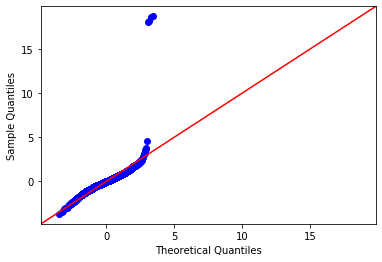

In [30]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [31]:
len(model.resid)

3844

In [32]:
X_train.shape

(15372, 110)

ValueError: x and y must be the same size

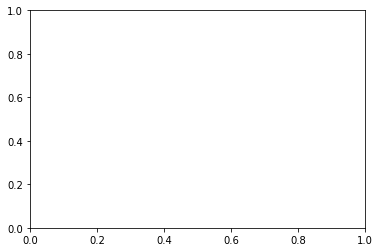

In [33]:
plt.scatter(model.predict(X_train[selected_columns]), model.resid)
plt.plot(model.predict(X_train[selected_columns]), [0 for i in range(len(X_train[selected_columns]))])